# Data Import

In [ ]:
from datetime import datetime 
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import time

# Now, we can use pandas read_excel after installing the excel importer.
!pip install -q xlrd


In [ ]:
df_artists = pd.read_excel('artists.xlsx')
df_listening_counts = pd.read_excel('user_artists.xlsx')
df_friends = pd.read_excel('user_friends.xlsx')

   1892 users, 17632 artists
      
   12717 bi-directional user friend relations, i.e. 25434 (user_i, user_j) pairs
         avg. 13.443 friend relations per user
         
   92834 user-listened artist relations, i.e. tuples (user, artist, listeningCount)
         avg. 49.067 artists most listened by each user
         avg. 5.265 users who listened each artist
            
   11946 tags  
   
  186479 tag assignments (tas), i.e. tuples (user, tag, artist)
         avg. 98.562 tas per user
         avg. 14.891 tas per artist
         avg. 18.930 distinct tags used by each user
         avg. 8.764 distinct tags used for each artist


In [ ]:
print(df_artists)
print(df_listening_counts)
print(df_friends)

       artistID               name
0             1       MALICE MIZER
1             2    Diary of Dreams
2             3  Carpathian Forest
3             4       Moi dix Mois
4             5        Bella Morte
...         ...                ...
17627     18741    Diamanda GalĂˇs
17628     18742             Aya RL
17629     18743        Coptic Rain
17630     18744       Oz Alchemist
17631     18745   Grzegorz Tomczak

[17632 rows x 2 columns]
       userID  artistID  weight
0           2        51   13883
1           2        52   11690
2           2        53   11351
3           2        54   10300
4           2        55    8983
...       ...       ...     ...
92829    2100     18726     337
92830    2100     18727     297
92831    2100     18728     281
92832    2100     18729     280
92833    2100     18730     263

[92834 rows x 3 columns]
       userID  friendID
0           2       275
1           2       428
2           2       515
3           2       761
4           2       831


Choose RELEVANT artists

In [ ]:
# calculate artist mentions
df_A_M = df_listening_counts.groupby(['artistID']).agg(UserCount=pd.NamedAgg(column="userID", aggfunc="count"))
df_A_M = df_A_M.reset_index()
df_A_M.shape

(17632, 2)

Maximum number of mentiones for artists: 611
Average number of mentiones per artist: 5.265086206896552


Text(0.5, 0, 'Number of Fans')

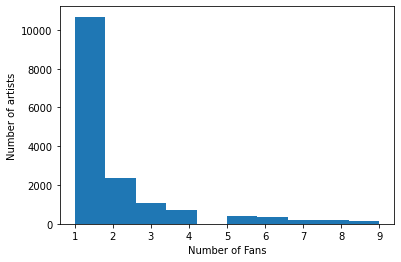

In [ ]:
# som stats
print("Maximum number of mentiones for artists: {}".format(max(df_A_M['UserCount'])))
print("Average number of mentiones per artist: {}".format(np.mean(df_A_M['UserCount'])))
# hitogram fo mentions with < 10
plt.hist(df_A_M['UserCount'].loc[df_A_M['UserCount'] < 10])
plt.ylabel('Number of artists')
plt.xlabel('Number of Fans')


# Choose relevant artists (HERE!)

In [ ]:
# TIME
TIME_START = time.time()


In [ ]:
# choose artis with more than ? mentions 
# select 5 or 2
artists = df_A_M['artistID'].loc[df_A_M['UserCount'] >= 2]
print("Number of artists: {}".format(len(artists)))

Number of artists: 6953


In [ ]:
 # ommit other artists
 df_NEW = df_listening_counts.loc[df_listening_counts['artistID'].isin(artists)]
 df_NEW = df_NEW.join(df_artists.set_index( 'artistID'), on= 'artistID', how='inner')
 df_NEW.shape

(82155, 4)

In [ ]:
# Remove rows with less then 10 listenings
# df_NEW.loc[df_NEW['weight'] < 50]

In [ ]:
 # create weight bins for listening counts
 df_NEW['weightQuantile'] = pd.qcut(df_NEW['weight'], q=10)
 bin_labels_10 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
 df_NEW['weightLabel'] = pd.qcut( df_NEW['weight'],
                              q=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
                              labels=bin_labels_10)
 print('Counts for weight labes')
 print(df_NEW[['weightQuantile','weightLabel']].value_counts())
 df_NEW.reset_index(drop=True, inplace=True)
 df_NEW.shape 

Counts for weight labes
weightQuantile      weightLabel
(42.0, 91.0]        2              8322
(200.0, 276.0]      5              8251
(141.0, 200.0]      4              8240
(0.999, 42.0]       1              8226
(536.0, 810.0]      8              8223
(1464.0, 352698.0]  10             8210
(810.0, 1464.0]     9              8205
(380.0, 536.0]      7              8198
(91.0, 141.0]       3              8146
(276.0, 380.0]      6              8134
dtype: int64


(82155, 6)

In [ ]:
# Summary
print("Number of Users: {}".format(len(df_NEW['userID'].unique())))
print("Number of artists: {}".format(len(df_NEW['artistID'].unique())))
print("Number of listening relations: {}".format(len(df_NEW['artistID'])))

Number of Users: 1885
Number of artists: 6953
Number of listening relations: 82155


# Itemrank

In [ ]:
from ItemRank import ItemRank
from sklearn.utils import shuffle
from sklearn import preprocessing

Traning and Test Split (Test split are connections labeled with 1)

In [ ]:
# shuggle dataset
df_NEW_shuffled = shuffle(df_NEW, random_state=1)
df_NEW_shuffled

,userID,artistID,weight,name,weightQuantile,weightLabel
53557,509,1854,11,Breaking Benjamin,"(0.999, 42.0]",1
37592,502,903,272,Amy Winehouse,"(200.0, 276.0]",5
25500,1505,489,292,Limp Bizkit,"(276.0, 380.0]",6
33996,601,726,907,Apocalyptica,"(810.0, 1464.0]",9
47915,1350,1394,368,The Chemical Brothers,"(276.0, 380.0]",6
...,...,...,...,...,...,...
21440,849,418,326,Sigur RĂłs,"(276.0, 380.0]",6
73349,1002,6429,56,Kate Ryan,"(42.0, 91.0]",2
50057,217,1504,100,Sonic Youth,"(91.0, 141.0]",3
5192,1937,163,1078,Pink Floyd,"(810.0, 1464.0]",9


In [ ]:
# select 40k training reviews for dataset with 2828
# select 45k training reviews for dataset with 4510 artists
df_TRAIN = df_NEW_shuffled[:45000]
df_TRAIN.insert(6, 'Label', 0)
print("Number of Users: {}".format(len(df_TRAIN['userID'].unique())))
print("Number of artists: {}".format(len(df_TRAIN['artistID'].unique())))
print("Number of listening relations: {}".format(len(df_TRAIN['artistID'])))

Number of Users: 1881
Number of artists: 6357
Number of listening relations: 45000


In [ ]:
# and the rest are test reviews (connection that arised)
df_TEST = df_NEW_shuffled[45000:]
df_TEST.insert(6, 'Label', 1)
print("Number of Users: {}".format(len(df_TEST['userID'].unique())))
print("Number of artists: {}".format(len(df_TEST['artistID'].unique())))
print("Number of listening relations: {}".format(len(df_TEST['artistID'])))

Number of Users: 1884
Number of artists: 6022
Number of listening relations: 37155


In [ ]:
# dealing with intersect or rather artists that are not in both datasets
pd.Series(list(set(df_TRAIN['artistID']).intersection(set(df_TEST['artistID']))))

0          1
1          2
2          3
3          4
4          6
        ... 
5421    8173
5422    8176
5423    8178
5424    8182
5425    8188
Length: 5426, dtype: int64

In [ ]:
# User not contained in test set
set(df_TRAIN['userID']).difference(set(df_TEST['userID']))

{1307}

In [ ]:
# numpy array conversion for itemrank algorithm
np_data = np.array(df_TRAIN[['userID', 'artistID', 'weightLabel']])
print(np_data.shape)

(45000, 3)


In [ ]:
np_data_test = np.array(df_TEST[['userID', 'artistID', 'weightLabel']])
print(np_data_test.shape)

(37155, 3)


In [ ]:
start_time = time.time()

# generate object
item_rank = ItemRank(np_data)

item_rank.generate_graph()
item_rank.generate_coef_from_graph()
print(item_rank.correlation_matrix.shape)

Exec_time_CM = round((time.time() - start_time)/60)
print("Initial settings Execution Time: {}".format(Exec_time_CM))

(6357, 6357)
Initial settings Execution Time: 1


In [ ]:
# calculate itemranks
start_time = time.time()
IRs = []
DOAs = []
UserCounter = 0
for user_name in item_rank.user_names:
    UserCounter +=  1
    d = item_rank.generate_d(user_name=user_name)
    IR = np.ones(len(item_rank.movie_names))
    old_IR = IR
    converged = False
    counter = 0
    while not converged:
      counter += 1
      old_IR = IR
      IR = item_rank.item_rank(0.85 , IR , d)
      converged = (old_IR - IR < 0.0001).all()
    print( "Converged after "+str(counter)+" counts.")
    print("User counter: {}".format(UserCounter))
    Exec_time_R = round((time.time() - start_time)/60)
    print("Execution time: {}".format(Exec_time_R))
    IRs.append(IR)

    if user_name in np_data_test[:,0]:      
      doa = item_rank.calculate_DOA(np_data_test, user_name , IR)
      DOAs.append(doa)
      print("DOA for user %s is : %s" %(user_name, doa))

np.array(IRs).shape

Streaming output truncated to the last 5000 lines.
DOA for user 680 is : 0.9413303077121153
Converged after 71 counts.
User counter: 632
Execution time: 158
DOA for user 681 is : 0.8405561559210695
Converged after 70 counts.
User counter: 633
Execution time: 159
DOA for user 682 is : 0.9229182619013128
Converged after 70 counts.
User counter: 634
Execution time: 159
DOA for user 683 is : 0.9016869388937157
Converged after 70 counts.
User counter: 635
Execution time: 159
DOA for user 684 is : 0.9957203076230009
Converged after 70 counts.
User counter: 636
Execution time: 159
DOA for user 685 is : 0.9200166594234391
Converged after 70 counts.
User counter: 637
Execution time: 160
DOA for user 686 is : 0.932005792903693
Converged after 71 counts.
User counter: 638
Execution time: 160
DOA for user 687 is : 0.8457754629629629
Converged after 70 counts.
User counter: 639
Execution time: 160
DOA for user 688 is : 0.9869545659019343
Converged after 71 counts.
User counter: 640
Execution time: 

(1881, 6357)

In [ ]:
# average performance DOA (percentage of movie paires ranked in correct order)
sum(DOAs)/len(DOAs)

0.9042861211893304

In [ ]:
df_IRs = pd.DataFrame(IRs)
df_IRs.columns = item_rank.movie_names
df_IRs['userID'] = item_rank.user_names
cols = list(df_IRs.columns)
cols = [cols[-1]] + cols[:-1]
df_IRs = df_IRs[cols]
df_IRs

,userID,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,23,24,25,26,27,28,30,31,32,34,36,37,38,39,40,41,43,45,46,47,48,...,16727,16742,16748,16751,16765,16771,16840,16891,16892,16920,16923,16950,16952,16970,17067,17093,17094,17120,17138,17189,17194,17230,17283,17284,17285,17294,17331,17485,17616,17685,17744,17798,17875,17903,17956,17962,17981,17982,18026,18038
0,2,0.008735,0.034795,0.002814,0.003316,0.008349,0.015118,0.337533,0.028075,0.049631,0.013676,0.009926,0.030379,0.021637,0.051159,0.014374,0.016335,0.023771,0.028565,0.004799,0.017780,0.028184,0.004873,0.017291,0.013403,0.090922,0.013825,0.040937,0.029045,0.032375,0.009563,0.003370,0.026964,0.045710,0.016544,0.007588,0.074226,0.004034,0.004892,0.006691,...,0.004485,0.006795,0.005823,0.008970,0.005893,0.002277,0.003874,0.004993,0.003874,0.005664,0.003178,0.007382,0.007583,0.003424,0.005695,0.010927,0.006908,0.001500,0.003287,0.007274,0.004709,0.006097,0.002137,0.003709,0.003709,0.005621,0.009356,0.005703,0.006455,0.003166,0.003533,0.003486,0.003366,0.003486,0.008223,0.014982,0.008809,0.001303,0.005125,0.001314
1,3,0.000664,0.002194,0.000209,0.000258,0.000609,0.001047,0.020607,0.001907,0.003928,0.001092,0.000545,0.002247,0.001344,0.003424,0.000673,0.001231,0.001390,0.006666,0.000335,0.000928,0.001927,0.000238,0.001108,0.001028,0.004655,0.001102,0.001595,0.001730,0.002100,0.000587,0.000309,0.001525,0.002503,0.001034,0.000191,0.005637,0.000249,0.000388,0.000500,...,0.000296,0.001784,0.001265,0.001666,0.000368,0.000112,0.000257,0.000366,0.000257,0.000316,0.000170,0.000462,0.000569,0.000177,0.000777,0.000856,0.000838,0.000120,0.000215,0.000893,0.000374,0.000423,0.000122,0.000255,0.000255,0.001594,0.000236,0.000308,0.000320,0.000207,0.000249,0.000319,0.000436,0.000319,0.001262,0.001190,0.001215,0.000143,0.000392,0.000894
2,4,0.006539,0.028500,0.002072,0.004732,0.007711,0.010126,0.214292,0.018639,0.032083,0.008702,0.010536,0.024764,0.012744,0.045303,0.008838,0.011593,0.016315,0.020838,0.003522,0.008059,0.024682,0.002256,0.007539,0.009282,0.055120,0.009898,0.021394,0.015345,0.018743,0.004723,0.002221,0.012972,0.027658,0.008983,0.002002,0.053981,0.002259,0.003638,0.006004,...,0.002337,0.003913,0.004157,0.005786,0.006373,0.001487,0.002015,0.003140,0.002015,0.004215,0.002042,0.004666,0.003903,0.002159,0.003265,0.004349,0.003985,0.000912,0.002383,0.004129,0.003333,0.004010,0.001955,0.003010,0.003010,0.003451,0.005211,0.003268,0.004136,0.001910,0.001916,0.001820,0.004830,0.001820,0.005004,0.004007,0.005207,0.000734,0.003135,0.000789
3,5,0.004203,0.011150,0.001128,0.002353,0.002778,0.005933,0.132443,0.011419,0.015862,0.004537,0.002582,0.012780,0.006401,0.019539,0.003149,0.004985,0.007421,0.007901,0.001872,0.003487,0.010578,0.001011,0.004353,0.005345,0.024637,0.005066,0.008595,0.008389,0.011201,0.002198,0.000893,0.006870,0.014439,0.003910,0.000946,0.033560,0.001444,0.002049,0.002735,...,0.001181,0.002653,0.001975,0.003176,0.002175,0.000682,0.001374,0.002198,0.001374,0.001912,0.001084,0.002969,0.004688,0.000996,0.003482,0.003196,0.003047,0.000571,0.001637,0.003710,0.001596,0.002290,0.000636,0.001201,0.001201,0.002179,0.001368,0.001623,0.001709,0.001337,0.001475,0.002265,0.003625,0.002265,0.004383,0.003577,0.002694,0.000472,0.003531,0.000294
4,6,0.000647,0.001724,0.000204,0.000234,0.000432,0.001045,0.025427,0.002081,0.002481,0.000715,0.000408,0.002117,0.001137,0.003528,0.000585,0.000809,0.001204,0.001417,0.000354,0.000681,0.001885,0.000199,0.000704,0.000976,0.004740,0.000761,0.001338,0.001364,0.001653,0.000413,0.000149,0.001682,0.002390,0.000668,0.000243,0.005599,0.000216,0.000356,0.000470,...,0.000235,0.000663,0.000390,0.000531,0.000653,0.000243,0.000260,0.000411,0.000260,0.000548,0.000342,0.000488,0.000486,0.000313,0.000385,0.000529,0.000473,0.001615,0.000215,0.000750,0.000304,0.001101,0.000304,0.000605,0.000605,0.000683,0.000403,0.000458,0.000369,0.000253,0.000237,0.000202,0.000287,0.000202,0.000706,0.002937,0.000552,0.000204,0.000278,0.000068
...,...,...,...,...,...,...,...,...,...,...,.

In [ ]:
# save dataset
df_IRs.to_csv('Dataset_2_IR.csv', index = False)

# Feature engneering

In [ ]:
import random

In [ ]:
# save pairs with label 1 - from network itemrank test pairs
df_Label1 = df_TEST[['userID','artistID', 'name', 'Label']]
df_Label1.shape

(37155, 4)

In [ ]:
# select label 0 connections 
# generate 40k random for Dataset_2 and 35k random for Dataset_1
random.seed(30)
df_Label0 = pd.DataFrame(index=range(40000), columns=['userID', 'artistID'])
for i in range(40000):    
    df_Label0['userID'][i] = random.choice(list(df_Label1['userID'].unique()))
    df_Label0['artistID'][i]= random.choice(list(df_Label1['artistID'].unique()))

In [ ]:
# drop duplicates
df_Label0 = df_Label0.drop_duplicates()
df_Label0.insert(2, 'Label', 0)

In [ ]:
# filter pairs that already exists

# create dataframe with existing pairs
df_exist = df_NEW[['userID', 'artistID']]
df_exist.insert(2, 'Label2', 2)
# left join to labeled0
df_Label0_adj = df_Label0.join(df_exist.set_index(['userID', 'artistID']), on= ['userID', 'artistID'], how='left')
# now remove interseted paires
df_Label0_final = df_Label0_adj[['userID', 'artistID', 'Label']].loc[~(df_Label0_adj['Label2']==2)]
# join artist name
df_Label0_final = df_Label0_final.join(df_artists.set_index('artistID'), on= 'artistID', how='inner')
df_Label0_final = df_Label0_final[['userID','artistID','name','Label']] 

In [ ]:
# join to labeled1
df_Labeled_Final = pd.concat([df_Label1, df_Label0_final])
df_Labeled_Final

,userID,artistID,name,Label
18596,425,333,Avril Lavigne,1
15300,875,300,Katy Perry,1
71406,1447,3712,The Lonely Island,1
38046,1840,910,John Williams,1
70823,820,5352,Jean-Jacques Perrey,1
...,...,...,...,...
37619,326,1730,Teitur,0
39469,903,1730,Teitur,0
38889,635,1428,Dulce MarĂ­a,0
39236,237,4336,Vision Divine,0


Now we will add itemrank metric

In [ ]:
df_Labeled = df_Labeled_Final

In [ ]:
# add IR to labeled pairs
ARTS = df_IRs.columns.tolist()
USRS = df_IRs['userID'].tolist()
hodnoty = []
ir = 0
for i in range(len(df_Labeled)):
    if (df_Labeled['artistID'].values[i] in ARTS) and (df_Labeled['userID'].values[i] in USRS):
        ir = df_IRs[df_Labeled['artistID'].values[i]].loc[df_IRs['userID'] == df_Labeled['userID'].values[i]].values[0]
        hodnoty.append(ir) 
    else:
        hodnoty.append('NX')

# removes pairs we didn't get ir
df_Labeled['IR'] = hodnoty
df_Labeled = df_Labeled.loc[~(df_Labeled['IR'] == 'NX')]

In [ ]:
df = df_Labeled
df = shuffle(df, random_state=0)
df

,userID,artistID,name,Label,IR
38959,853,5640,Nitrominds,0,0.00209799
75024,1275,7266,Pete Townshend,1,0.00468973
15465,1649,300,Katy Perry,1,1.44015
28670,552,3440,Ween,0,0.000202919
46945,1707,1358,Judas Priest,1,0.0879756
...,...,...,...,...,...
74954,467,7232,Jean-Jacques Goldman,1,0.0381417
11133,229,1404,Lone,0,0.00126228
30121,1625,2341,Twisted Sister,0,0.00214983
32104,2013,15083,Mondo Grosso,0,0.00295412


Adding column that represents number of friends that listned to same artist

In [ ]:
df_known = df_TRAIN[['userID','artistID', 'name']] 
USERS = df_known['userID'].unique()

In [ ]:
# extract all all existing edges
LISTENINGS = []
for user in USERS:
    LISTENINGS.append(list(df_known['artistID'].loc[df_known['userID'] == user].values))

In [ ]:
# filter for friends
Counts = []
for i in range(len(df_Labeled)):
    count = 0
    U = df_Labeled['userID'].values[i]
    A = df_Labeled['artistID'].values[i]

    for j in range(len(df_friends.loc[df_friends['userID'] == U])):       
        #save name
        friend = df_friends['friendID'].loc[df_friends['userID'] == U].values[j]
        #locate in LISTENINGS
        if friend in USERS:
            pos = list(USERS).index(friend)
            #check for song
            if A in LISTENINGS[pos]:
                  count +=1

    Counts.append(count)

In [ ]:
df_Labeled['FriendsListening'] = np.asarray(Counts[:])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df = df_Labeled
random.seed(30)
df = shuffle(df, random_state=0)
df

,userID,artistID,name,Label,IR,FriendsListening
38959,853,5640,Nitrominds,0,0.00209799,0
75024,1275,7266,Pete Townshend,1,0.00468973,0
15465,1649,300,Katy Perry,1,1.44015,3
28670,552,3440,Ween,0,0.000202919,0
46945,1707,1358,Judas Priest,1,0.0879756,0
...,...,...,...,...,...,...
74954,467,7232,Jean-Jacques Goldman,1,0.0381417,0
11133,229,1404,Lone,0,0.00126228,0
30121,1625,2341,Twisted Sister,0,0.00214983,0
32104,2013,15083,Mondo Grosso,0,0.00295412,0


FriendsListening analysis

0.7966960660786784
2.8014856268365467
49


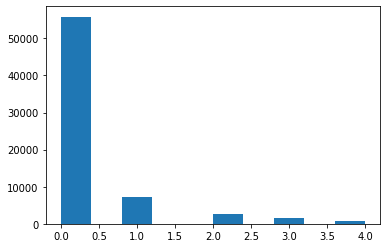

In [ ]:
plt.hist(df['FriendsListening'].loc[df['FriendsListening'] < 5])
print(np.mean(df['FriendsListening']))
print(np.std(df['FriendsListening']))
print(max(df['FriendsListening']))

In [ ]:
plt.hist(df['FriendsListening'].loc[(df['FriendsListening'] >= 12)& (df['FriendsListening'] <= 25)])

(array([62., 33., 32., 30., 12.,  9.,  6.,  3.,  0.,  1.]),
 array([26. , 28.3, 30.6, 32.9, 35.2, 37.5, 39.8, 42.1, 44.4, 46.7, 49. ]),
 <a list of 10 Patch objects>)

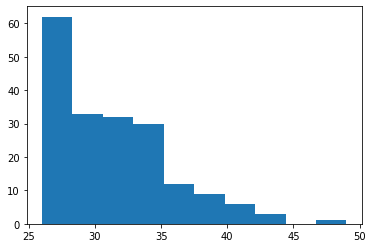

In [ ]:
plt.hist(df['FriendsListening'].loc[df['FriendsListening'] > 25])

In [ ]:
# create a list of our conditions
conditions = [
    (df['FriendsListening'] == 0),
    (df['FriendsListening'] == 1),
    (df['FriendsListening'] >= 2) & (df['FriendsListening'] < 5),
    (df['FriendsListening'] >= 5) & (df['FriendsListening'] < 11),
    (df['FriendsListening'] >= 11) & (df['FriendsListening'] < 20),
    (df['FriendsListening'] >= 20) 
    ]
values = [0, 1, 2, 3, 4, 5]
df['FriendsRating'] = np.select(conditions, values)[:]

In [ ]:
plt.hist(df['FriendsRating'].loc[df['FriendsRating'] > 1])

In [ ]:
print(len(df.loc[df['Label'] ==1]))
print(len(df.loc[df['Label'] ==0]))
df


35768
35662


,userID,artistID,name,Label,IR,FriendsListening,FriendsRating
38959,853,5640,Nitrominds,0,0.00209799,0,0
75024,1275,7266,Pete Townshend,1,0.00468973,0,0
15465,1649,300,Katy Perry,1,1.44015,3,2
28670,552,3440,Ween,0,0.000202919,0,0
46945,1707,1358,Judas Priest,1,0.0879756,0,0
...,...,...,...,...,...,...,...
74954,467,7232,Jean-Jacques Goldman,1,0.0381417,0,0
11133,229,1404,Lone,0,0.00126228,0,0
30121,1625,2341,Twisted Sister,0,0.00214983,0,0
32104,2013,15083,Mondo Grosso,0,0.00295412,0,0


In [ ]:
# save dataset
df.to_csv('Dataset_2.csv', index = False)

In [ ]:
TOTAL_EXEC_TIME = round((time.time() - start_time)/60)
print("TOTAL: {}".format(TOTAL_EXEC_TIME))

TOTAL: 532
